In [29]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score

In [30]:
df = pd.read_csv('./data/tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)

In [31]:
data = df[['AAPL.O','MSFT.O','INTC.O','AMZN.O','GS.N']].dropna()
AAPL = data['AAPL.O']
MSFT = data['MSFT.O']
INTC = data['INTC.O']
AMZN = data['AMZN.O']
GS = data['GS.N']

In [157]:
def get_pre(raw, order):
    
    def arima_forecast(traindata, obs):
        model = ARIMA(traindata, order=order).fit()
        pre_y = model.forecast()[0]
        traindata.append(obs)  # Update traindata with the new observation
        return pre_y
    
    # Split data into training data and testing data
    values = raw.values
    size = int(len(values) * 0.8)
    train = values[:size]
    test = values[size:len(values)]
    
    trainl = train.tolist()
    predictions = []
    for obs in test:
        pre_y = arima_forecast(trainl, obs)
        predictions.append(pre_y)
    
    return predictions

In [137]:
def generate_signals(prices, pct_within=0.01):
    signals = np.zeros(len(prices))
    for i in range(1, len(prices)):
        if i == len(prices) - 1:
            break
        current_price = prices[i]
        next_price = prices[i + 1]
        upper_bound = current_price * (1 + pct_within)
        lower_bound = current_price * (1 - pct_within)
        
        if next_price >= lower_bound and next_price <= upper_bound:
            signals[i] = signals[i - 1] if signals[i - 1] != 0 else 1  # Maintain previous position if within range
        elif next_price > upper_bound:
            signals[i] = 1  # Buy signal
        elif next_price < lower_bound:
            signals[i] = -1  # Sell signal
    
    return signals

In [97]:
def total_returns(stock, stock_name, raw, predictions):
    datastock = pd.DataFrame(raw[stock_name].dropna()[int(len(stock.values) * 0.8):])
    datastock['Returns'] = np.log(datastock[stock_name] / datastock[stock_name].shift(1))
    datastock['direction'] = np.sign(datastock['Returns']).dropna().astype(int)
    datastock['pre']= predictions
    datastock['signals'] = generate_signals(datastock['pre'])
    datastock['strategy'] = datastock['signals'] * datastock['Returns']
    return datastock[['Returns', 'strategy']].sum().apply(np.exp)

In [ ]:
#AAPL.O (2,1,2) -> (0,1,0)

In [98]:
sizeL = int(len(AAPL.values) * 0.8)
trainL = AAPL[:sizeL]
testL = AAPL[sizeL:]

In [99]:
# Use auto_arima to find the best order(p,d,q)
bestmodel = auto_arima(trainL, seasonal=False, trace=True).order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5860.243, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5863.226, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5864.599, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5864.563, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5863.676, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5866.270, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5868.582, Time=1.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5869.037, Time=1.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5869.029, Time=1.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5866.263, Time=0.75 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5867.467, Time=0.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5868.093, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5860.693, Time=1.05 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

In [37]:
# Due to the large length of the training data, if I enter the order (2,1,2), it will return error: The underlying 
# optimization algorithm does not converge/take a long time to converge. 

In [38]:
# The function ARIMA can work successfully only when the order is one of (0,1,0), (1,1,0), (0,1,1), (0,1,2).

In [39]:
# Since the smaller value of AIC, the better the order, I choose (0,1,1) instead which has an AIC value close
# to that of (2,1,2). 

In [40]:
# Similar situations to other stocks.

In [154]:
pre_AAPL = get_pre(AAPL, (0,1,0))

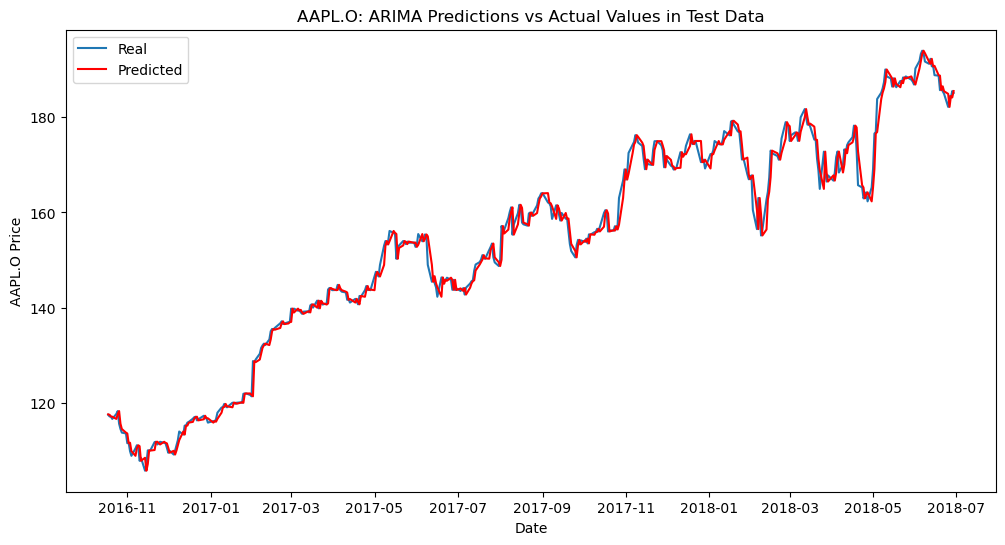

In [155]:
# Compare the test data with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testL, label='Real')
plt.plot(AAPL[sizeL:].index, pre_AAPL, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

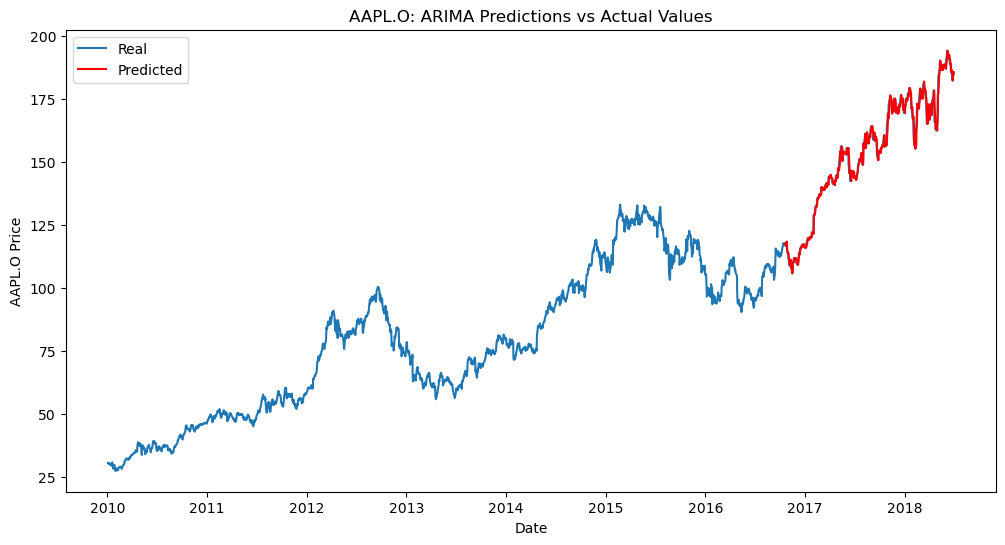

In [156]:
# Compare AAPL.O prices with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(AAPL, label='Real')
plt.plot(AAPL[sizeL:].index, pre_AAPL, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

In [138]:
total_returns(AAPL, 'AAPL.O', data, pre_AAPL)

Returns      1.575807
strategy    12.736946
dtype: float64

In [104]:
#MSFT.O 

In [105]:
sizeM = int(len(MSFT.values) * 0.8)
trainM = MSFT[:sizeM]
testM = MSFT[sizeM:]

In [106]:
bestmodel = auto_arima(trainM, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2868.600, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2860.659, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2862.604, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2862.604, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2859.955, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2864.607, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.945 seconds
(0, 1, 0)


In [107]:
pre_MSFT = get_pre(MSFT, (0,1,0))

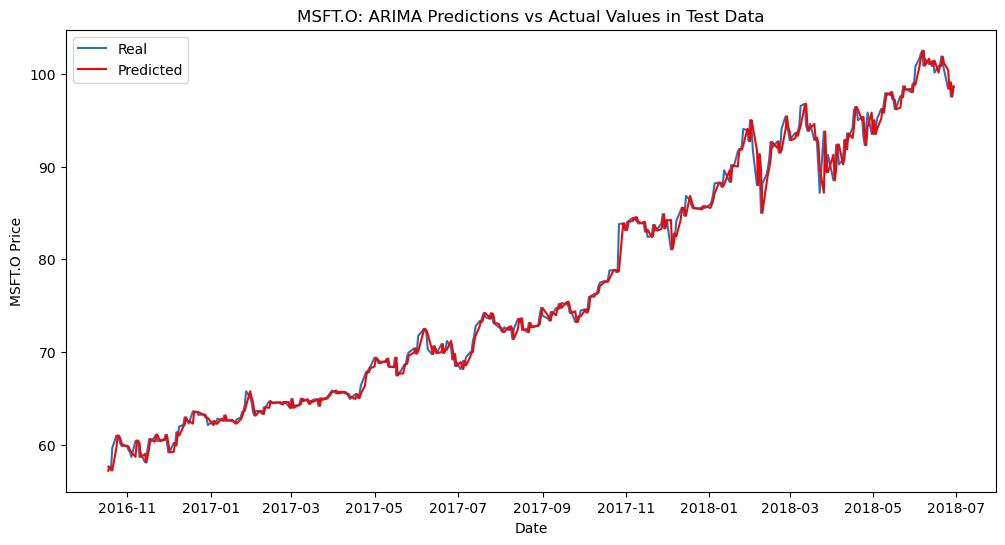

In [108]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testM, label='Real')
plt.plot(MSFT[sizeM:].index, pre_MSFT, color='red', label='Predicted')
plt.title('MSFT.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('MSFT.O Price')
plt.legend()
plt.show()

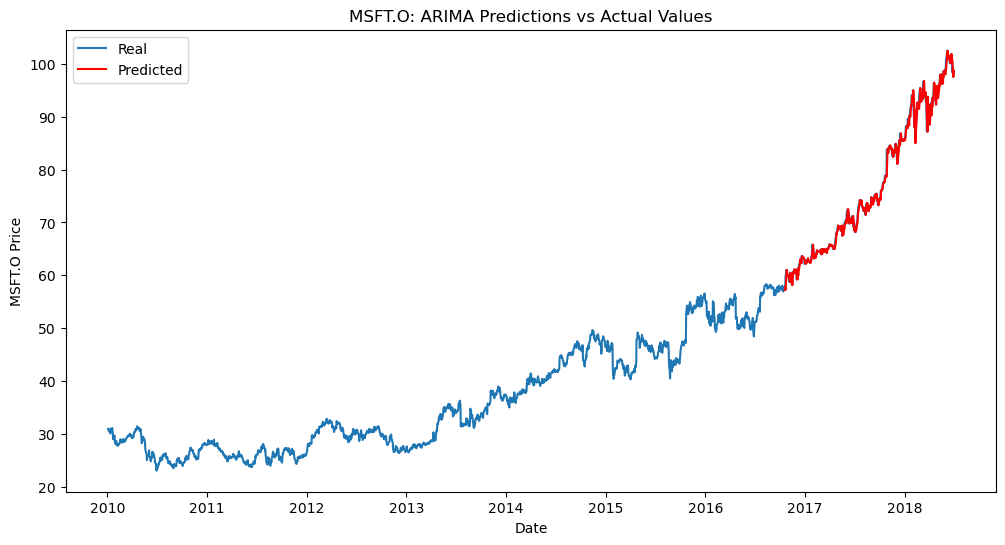

In [109]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(MSFT, label='Real')
plt.plot(MSFT[sizeM:].index, pre_MSFT, color='red', label='Predicted')
plt.title('MSFT.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('MSFT.O Price')
plt.legend()
plt.show()

In [139]:
total_returns(MSFT, 'MSFT.O', data, pre_MSFT)

Returns     1.710198
strategy    9.102215
dtype: float64

In [111]:
#INTC.O (0,1,0) -> (1,1,0)

In [112]:
sizeI = int(len(INTC.values) * 0.8)
trainI = INTC[:sizeI]
testI = INTC[sizeI:]

In [113]:
bestmodel = auto_arima(trainI, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1692.518, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1685.908, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1686.842, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1686.846, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1684.913, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1688.843, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.760 seconds
(0, 1, 0)


In [115]:
pre_INTC = get_pre(INTC, (1,1,0))

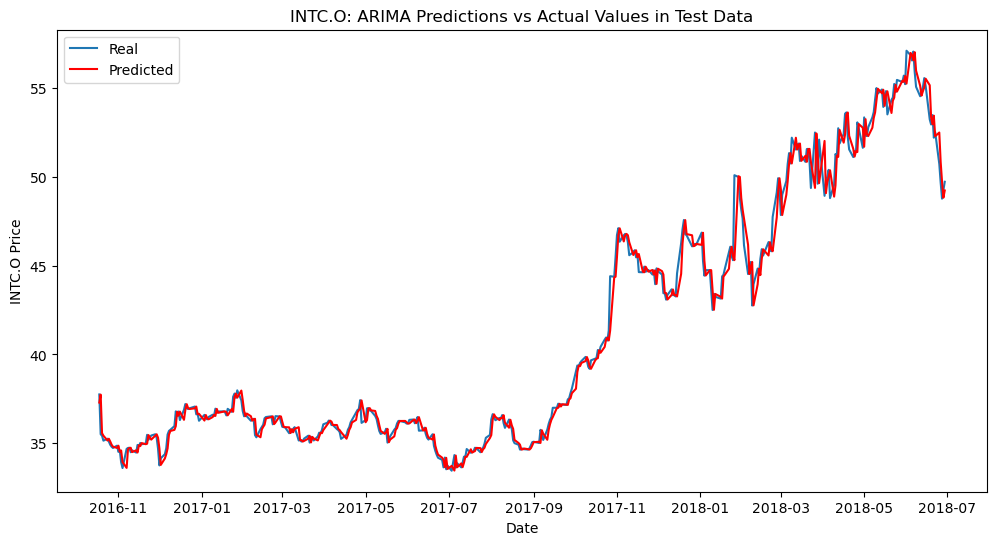

In [116]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testI, label='Real')
plt.plot(INTC[sizeI:].index, pre_INTC, color='red', label='Predicted')
plt.title('INTC.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('INTC.O Price')
plt.legend()
plt.show()

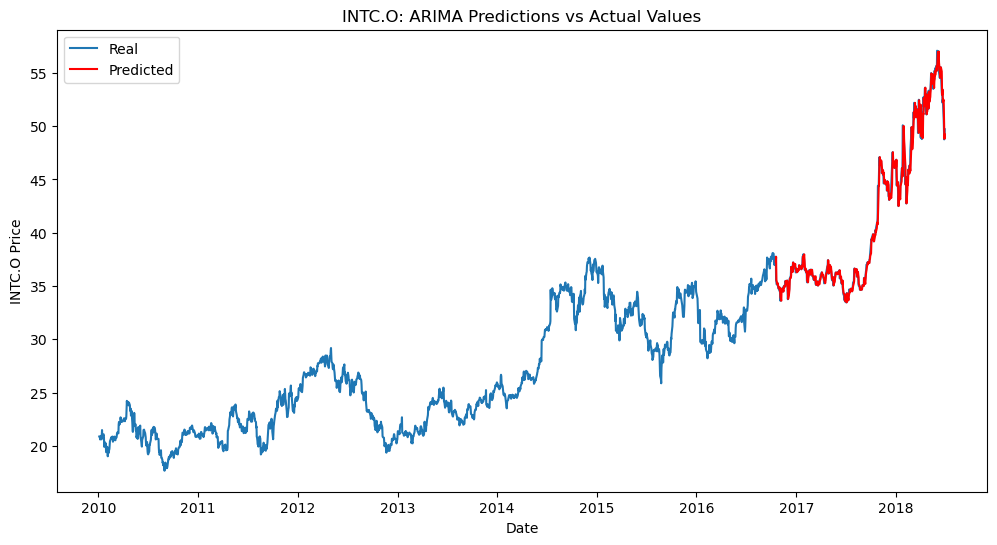

In [117]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(INTC, label='Real')
plt.plot(INTC[sizeI:].index, pre_INTC, color='red', label='Predicted')
plt.title('INTC.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('INTC.O Price')
plt.legend()
plt.show()

In [140]:
total_returns(INTC, 'INTC.O', data, pre_INTC)

Returns      1.316821
strategy    21.343844
dtype: float64

In [161]:
#AMZN.O 

In [119]:
sizeZ = int(len(AMZN.values) * 0.8)
trainZ = AMZN[:sizeZ]
testZ = AMZN[sizeZ:]

In [120]:
bestmodel = auto_arima(trainZ, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11490.883, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11492.853, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11492.853, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11494.427, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11494.879, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.645 seconds
(0, 1, 0)


In [121]:
pre_AMZN = get_pre(AMZN, (0,1,0))

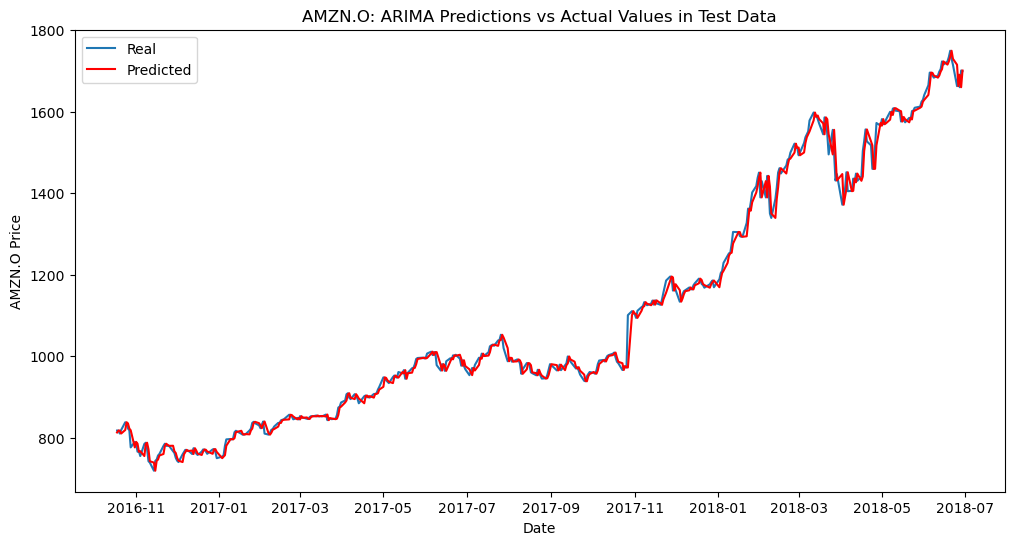

In [122]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testZ, label='Real')
plt.plot(AMZN[sizeZ:].index, pre_AMZN, color='red', label='Predicted')
plt.title('AMZN.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AMZN.O Price')
plt.legend()
plt.show()

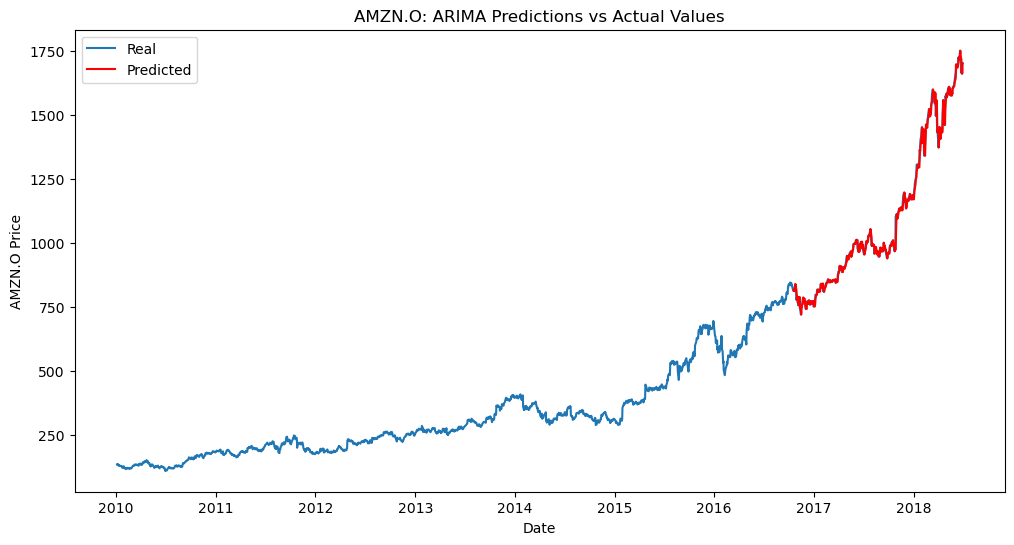

In [123]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(AMZN, label='Real')
plt.plot(AMZN[sizeZ:].index, pre_AMZN, color='red', label='Predicted')
plt.title('AMZN.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('AMZN.O Price')
plt.legend()
plt.show()

In [141]:
total_returns(AMZN, 'AMZN.O', data, pre_AMZN)

Returns      2.078885
strategy    27.525868
dtype: float64

In [169]:
#GS.N (1,1,1) -> (1,1,0)

In [125]:
sizeG = int(len(GS.values) * 0.8)
trainG = GS[:sizeG]
testG = GS[sizeG:]

In [126]:
bestmodel = auto_arima(trainG, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7941.907, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7946.862, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7942.513, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7942.633, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7944.863, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7940.247, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7944.465, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7940.167, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7940.306, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7944.369, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7938.169, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7940.635, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7940.515, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7938.308, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [127]:
pre_GS = get_pre(GS, (1,1,0))

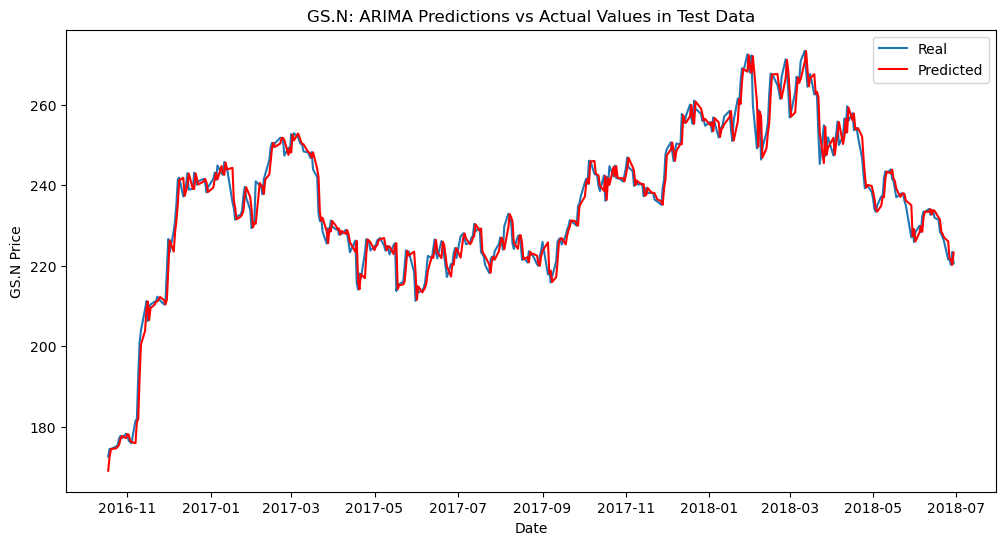

In [128]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testG, label='Real')
plt.plot(GS[sizeG:].index, pre_GS, color='red', label='Predicted')
plt.title('GS.N: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('GS.N Price')
plt.legend()
plt.show()

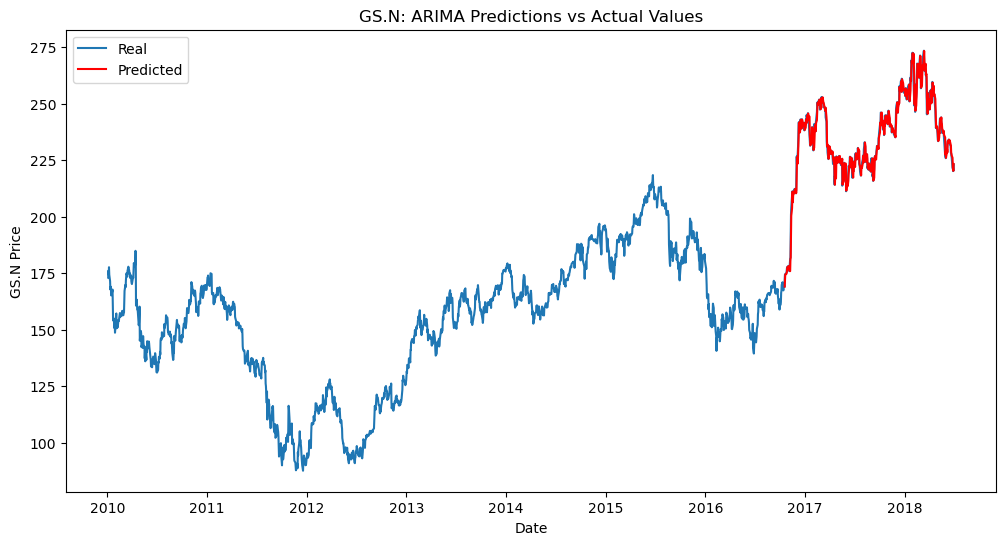

In [129]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(GS, label='Real')
plt.plot(GS[sizeG:].index, pre_GS, color='red', label='Predicted')
plt.title('GS.N: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('GS.N Price')
plt.legend()
plt.show()

In [142]:
total_returns(GS, 'GS.N', data, pre_GS)

Returns      1.277704
strategy    16.846032
dtype: float64

In [145]:
print(total_returns(AAPL, 'AAPL.O', data, pre_AAPL))
print(total_returns(MSFT, 'MSFT.O', data, pre_MSFT))
print(total_returns(INTC, 'INTC.O', data, pre_INTC))
print(total_returns(AMZN, 'AMZN.O', data, pre_AMZN))
print(total_returns(GS, 'GS.N', data, pre_GS))

Returns      1.575807
strategy    12.736946
dtype: float64
Returns     1.710198
strategy    9.102215
dtype: float64
Returns      1.316821
strategy    21.343844
dtype: float64
Returns      2.078885
strategy    27.525868
dtype: float64
Returns      1.277704
strategy    16.846032
dtype: float64
